**Make_3D_ocn_land_mask.ipynb**

**Purpose:** To make a 3D land mask (to use with the ocean component) for a given model run. The notebook also allows to test the conservation properties of such mask for any 3D variable of the ocean model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset

from PySCRIP.config import PySCRIPConfig
from PySCRIP import remap

In [3]:
from PyCESM.vars.integrate import mean

Loading some Temperature data, and grid data

In [4]:
var = "RHO"  # Load some 3D variable to generate mask with and test conservation property. 
# ncfile = Dataset("21ka.tier1.CN.001.pop.h.0475-02.nc","r")
ncfile = Dataset("21ka.tier1.CN.001.pop.h.0475-02.nc", "r")
ocndata = ncfile[var][:,:]
TAREA = ncfile["TAREA"][:,:]
KMT = ncfile["KMT"][:,:]
ncfile.close()
del ncfile

Loading the 2D surface continent mask

/Users/dchandan/local/miniconda3/envs/resc/lib/python3.6/site-packages/matplotlib/image.py:419: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


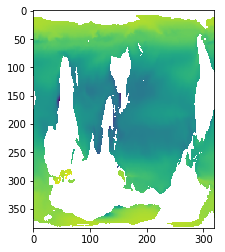

In [5]:
mask = ocndata[0,0,:,:]
plt.imshow(ocndata[0,0,:,:])

In [7]:
cmaskfname = "/Users/dchandan/Research/CESM/mapping/cmask_LGM6GC.nc"
ncfile = Dataset(cmaskfname, "r")
mask = ncfile.variables["mask"][:,:]
ncfile.close()

del ncfile

In [8]:
a = PySCRIPConfig()
m = a.getmap("21ka.tier1.CNDV.001", "conservative", "gx1", "ll1")

In [14]:
ocndata_1 = remap(ocndata[0,:,:,:], m.fname, m.format)

In [15]:
mask3d = np.logical_or(mask, abs(ocndata_1) > 10**6)
print(mask3d.shape)

(60, 180, 360)


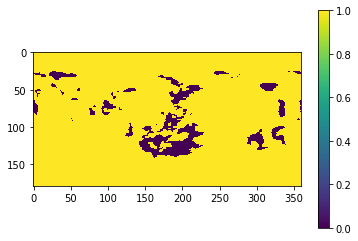

In [18]:
plt.imshow(mask3d[57,:,:].astype('f4')); plt.colorbar()

In [21]:
# Now, create a masked tempeture array
ocndata_1m = np.ma.MaskedArray(ocndata_1, mask=mask3d)

In [22]:
# We need to read in the surface cell areas of the ll1 grid for computing
# the means of the temperature on the ll1 grid.
ncfile = Dataset(m.fname, "r")
ll1areas = ncfile.variables["dst_grid_area"][:]
ll1areas = ll1areas.reshape((180,360))

In [24]:
for i in range(60):
    m1 = mean(ocndata[0,i,:,:], TAREA)
    m2 = mean(ocndata_1m[i,:,:], ll1areas)
    err = (m1-m2)*100/m1
    relerr = abs(m1 - m2)
    print("{3:3d}  {0:8.5f} {1:8.5f} {2:8.5f}  {4:8.5f}".format(m1, m2, abs(err), i, relerr))

  0   1.02519  1.02519  0.00010   0.00000
  1   1.02524  1.02524  0.00015   0.00000
  2   1.02531  1.02532  0.00021   0.00000
  3   1.02544  1.02544  0.00026   0.00000
  4   1.02563  1.02563  0.00025   0.00000
  5   1.02585  1.02585  0.00026   0.00000
  6   1.02605  1.02605  0.00024   0.00000
  7   1.02624  1.02624  0.00018   0.00000
  8   1.02642  1.02642  0.00013   0.00000
  9   1.02659  1.02659  0.00014   0.00000
 10   1.02677  1.02677  0.00012   0.00000
 11   1.02694  1.02694  0.00006   0.00000
 12   1.02710  1.02710  0.00004   0.00000
 13   1.02725  1.02725  0.00000   0.00000
 14   1.02739  1.02738  0.00002   0.00000
 15   1.02752  1.02752  0.00004   0.00000
 16   1.02764  1.02764  0.00005   0.00000
 17   1.02777  1.02777  0.00007   0.00000
 18   1.02789  1.02789  0.00005   0.00000
 19   1.02801  1.02801  0.00005   0.00000
 20   1.02814  1.02814  0.00004   0.00000
 21   1.02826  1.02826  0.00004   0.00000
 22   1.02839  1.02839  0.00010   0.00000
 23   1.02852  1.02852  0.00015   

I save the 3D mask to the same file as that with the continent mask. Edit the commands in the next cell as necessary.

In [25]:
ncfile = Dataset(cmaskfname, "a")

ncfile.createDimension("z", 60)

var = ncfile.createVariable("mask3d", "i2", ("z", "lat", "lon"), zlib=True)

# var[:,:,:] = mask3d

ncfile.variables["mask3d"][:,:,:] = mask3d

ncfile.close()